<a href="https://colab.research.google.com/github/banno-0720/Deep-Learning-Projects/blob/main/IntrusionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Downloading and importing the necessary libraries

In [1]:
!pip install opendatasets

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import requests
from pathlib import Path
import opendatasets as od

# 1. Load Dataset

In [3]:
od.download("https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: himanshugoyal2004
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset


100%|██████████| 230M/230M [00:01<00:00, 162MB/s]


In [4]:
def load_data():
    # Download dataset
    od.download("https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset")
    dataset_file = "/content/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

    # Load dataset into pandas DataFrame
    df = pd.read_csv(dataset_file)

    # Clean up column names (remove spaces and make lower case)
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    # # Inspect cleaned column names
    # print("Cleaned Columns in the dataset:")
    # print(df.columns)

    # Filter relevant columns
    features = ['flow_duration', 'total_fwd_packets', 'total_backward_packets',
                'fwd_packet_length_mean', 'bwd_packet_length_mean',
                'flow_packets/s', 'label']
    df = df[features]
    df.dropna(inplace=True)  # Handle missing values
    return df

# # Test the function
# data = load_data()
# print(data.head())


# 2. Preprocess Data

In [5]:
def preprocess_data(data):
    # Convert labels to binary (e.g., 'DDoS' -> 1, others -> 0)
    data['label'] = data['label'].apply(lambda x: 1 if x == 'DDoS' else 0)

    # Replace infinite values with NaN and drop them
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN values
    data.dropna(inplace=True)

    # Normalize numeric features
    scaler = MinMaxScaler()
    X = scaler.fit_transform(data.drop(columns=['label']))
    y = data['label'].values

    # Group data into sequences (example: group by batches of 10 rows)
    sequence_length = 10
    X_sequences, y_sequences = [], []
    for i in range(0, len(X) - sequence_length):
        X_sequences.append(X[i:i+sequence_length])
        y_sequences.append(y[i+sequence_length - 1])  # Label for the sequence

    return np.array(X_sequences), np.array(y_sequences)


# 3. PyTorch Dataset Class

In [6]:
class DDoSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 4. LSTM Model

In [7]:
class DDoSLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(DDoSLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])  # Use the last hidden state for classification
        return self.sigmoid(out)

# 5. Training Function

In [8]:
def train_model(model, train_loader, val_loader, epochs, learning_rate):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                val_preds.extend((outputs > 0.5).cpu().numpy())
                val_targets.extend(y_batch.cpu().numpy())

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {accuracy_score(val_targets, val_preds):.4f}")

# 6. Main Execution

In [9]:
data = load_data()
X, y = preprocess_data(data)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoaders
train_dataset = DDoSDataset(X_train, y_train)
val_dataset = DDoSDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define model
input_size = X.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DDoSLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Train model
train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001)

# Evaluate final performance
print("Training Complete!")


Skipping, found downloaded files in "./network-intrusion-dataset" (use force=True to force download)
Epoch 1/10, Train Loss: 0.0832, Val Loss: 0.0202, Val Accuracy: 0.9951
Epoch 2/10, Train Loss: 0.0209, Val Loss: 0.0111, Val Accuracy: 0.9964
Epoch 3/10, Train Loss: 0.0127, Val Loss: 0.0042, Val Accuracy: 0.9989
Epoch 4/10, Train Loss: 0.0092, Val Loss: 0.0038, Val Accuracy: 0.9990
Epoch 5/10, Train Loss: 0.0076, Val Loss: 0.0103, Val Accuracy: 0.9955
Epoch 6/10, Train Loss: 0.0069, Val Loss: 0.0025, Val Accuracy: 0.9992
Epoch 7/10, Train Loss: 0.0061, Val Loss: 0.0035, Val Accuracy: 0.9990
Epoch 8/10, Train Loss: 0.0058, Val Loss: 0.0032, Val Accuracy: 0.9988
Epoch 9/10, Train Loss: 0.0052, Val Loss: 0.0045, Val Accuracy: 0.9985
Epoch 10/10, Train Loss: 0.0046, Val Loss: 0.0033, Val Accuracy: 0.9991
Training Complete!


# 7. Visualization

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_distribution(data):
    plt.figure(figsize=(12, 8))
    sns.histplot(data=data, x="flow_duration", hue="label", kde=True, bins=50)
    plt.title("Distribution of Flow Duration by Label")
    plt.xlabel("Flow Duration")
    plt.ylabel("Frequency")
    plt.legend(["Benign", "DDoS"])
    plt.show()

In [11]:
def plot_detection_over_time(y_true, y_pred):
    plt.figure(figsize=(12, 6))
    time = np.arange(len(y_true))
    plt.plot(time, y_true, label="True Labels", alpha=0.6)
    plt.plot(time, y_pred, label="Predicted Labels", linestyle="--", alpha=0.6)
    plt.title("DDoS Detection Over Time")
    plt.xlabel("Time")
    plt.ylabel("Detection (0: Benign, 1: DDoS)")
    plt.legend()
    plt.show()

In [12]:
def plot_correlation_heatmap(data):
    plt.figure(figsize=(12, 10))
    corr = data.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Feature Correlation Heatmap")
    plt.show()

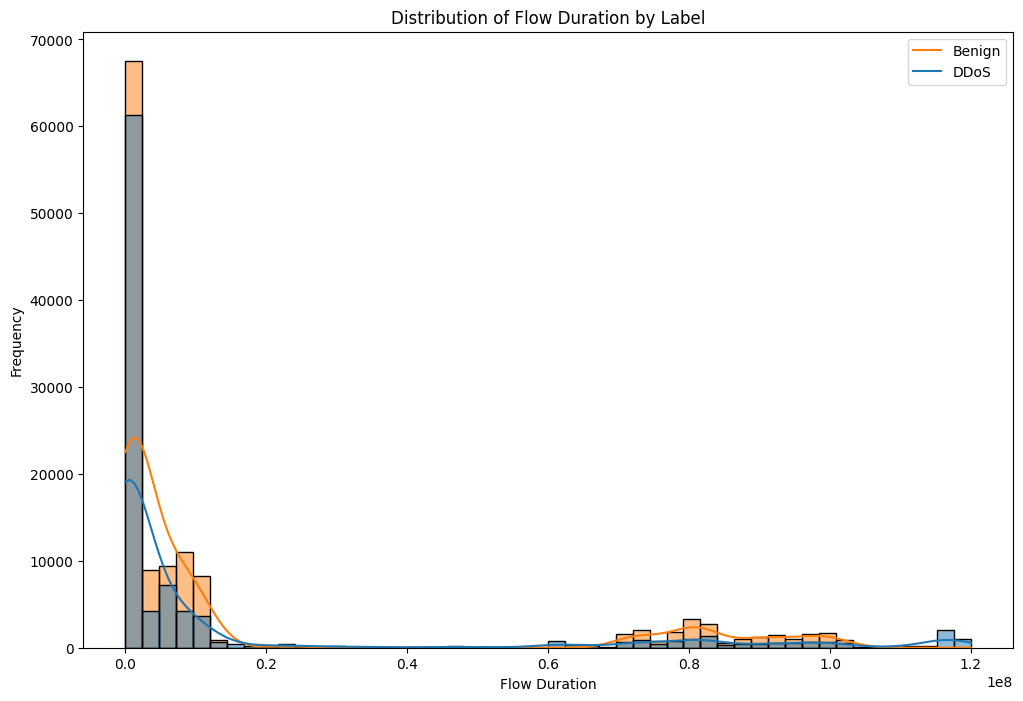

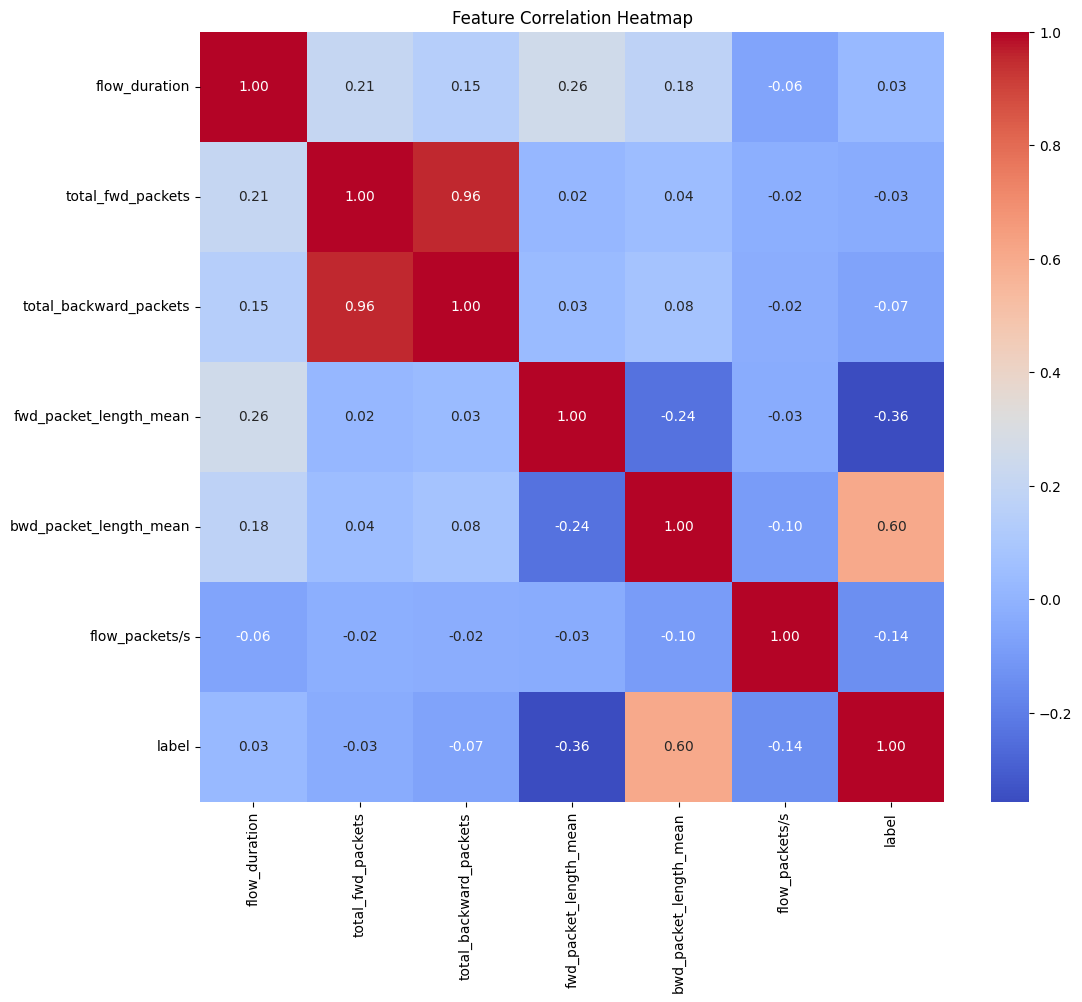

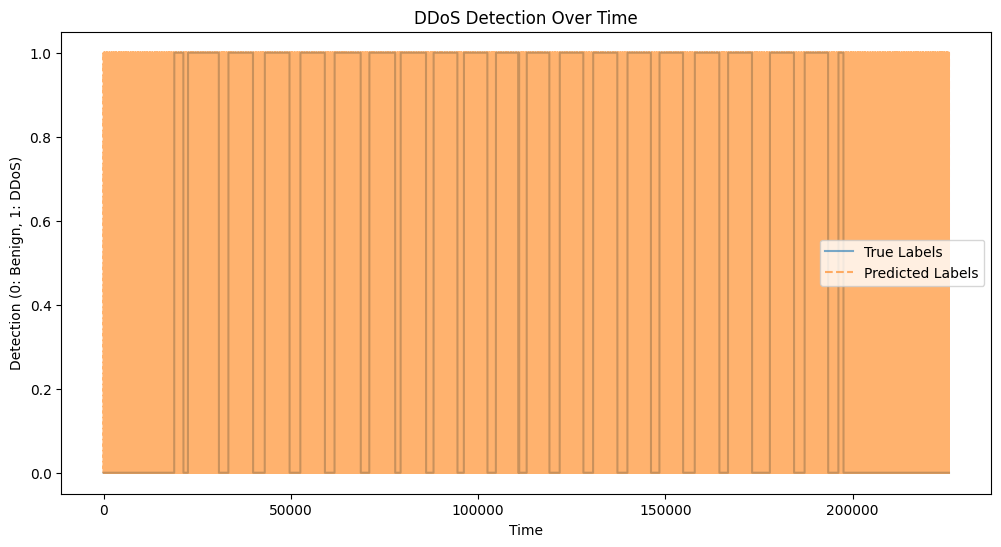

In [13]:
plot_feature_distribution(data)
plot_correlation_heatmap(data)
y_pred = (np.random.rand(len(y)) > 0.5).astype(int)  # Example random predictions
plot_detection_over_time(y, y_pred)

# 8. Random Predictions with the Model

In [15]:
def make_random_predictions(model, data_loader, num_samples=5):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).squeeze()
            preds = (outputs > 0.5).cpu().numpy()
            predictions.extend(zip(preds, y_batch.numpy()))

    # Randomly sample predictions
    random_samples = np.random.choice(len(predictions), num_samples, replace=False)
    print("Random Predictions:")
    for idx in random_samples:
        pred, true = predictions[idx]
        print(f"Predicted: {int(pred)}, True: {int(true)}")


In [16]:
make_random_predictions(model, val_loader, num_samples=5)

Random Predictions:
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 0, True: 0


# 9. Saving and Loading the model

In [17]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "DDoSLSTM_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/DDoSLSTM_model.pth


In [18]:
# Create a new instance
torch.manual_seed(42)
loaded_model = DDoSLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_gpu = loaded_model.to(device)

<ipython-input-18-c6cbf71589b6>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
